# Euchre Trick Model
Model to estimate the number of tricks a given hand will be able to take  
(or maybe the percent likelihood of each number of tricks taken 0-5)

In [1]:
import pandas as pd

In [70]:
raw_train_df = pd.read_csv('all_hand_results.csv')

In [71]:
raw_train_df.shape

(476716, 16)

In [72]:
raw_train_df.head()

,tricks_won,is_calling_player,teammate_called,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q,num_suits,partner_tricks,player_seat
0,2,1,0,1,0,0,0,0,1,1,0,1,0,2,1,4
1,0,0,0,0,0,0,0,0,0,0,0,1,0,3,2,1
2,1,0,1,0,1,0,1,0,0,0,0,0,1,2,2,2
3,2,0,0,0,0,0,0,1,0,0,1,1,1,3,0,3
4,3,1,0,1,0,0,1,0,1,0,0,0,1,2,0,2


In [73]:
raw_train_df.columns

Index(['tricks_won', 'is_calling_player', 'teammate_called', 'has_right',
       'has_left', 'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump',
       'has_9trump', 'num_off_A', 'num_off_K', 'num_off_Q', 'num_suits',
       'partner_tricks', 'player_seat'],
      dtype='object')

<AxesSubplot:>

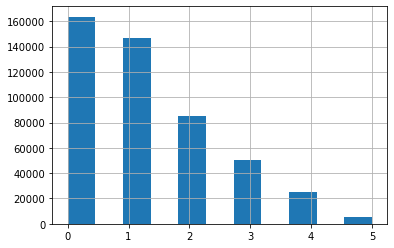

In [74]:
raw_train_df['tricks_won'].hist(bins=11)

In [75]:
raw_train_df['team_tricks_won'] = raw_train_df['partner_tricks'] + raw_train_df['tricks_won']

### Create train/test/validation splits

In [76]:
model_features = ['has_right', 'has_left',
                  'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump', 'has_9trump', 
                  'num_off_A', 'num_off_K', 'num_off_Q', 'num_suits', 'player_seat'
                 ]

In [78]:
from sklearn.model_selection import train_test_split

In [134]:
train_df, test_df, train_targets_df, test_targets_df = train_test_split(raw_train_df[model_features], 
                                                    raw_train_df['tricks_won'], 
                                                    test_size=0.33, random_state=41)

In [135]:
train_df.shape

(319399, 12)

In [136]:
test_df.shape

(157317, 12)

#### Scale Features

In [82]:
from sklearn.preprocessing import StandardScaler

In [83]:
sc = StandardScaler()
train_df = sc.fit_transform(train_df)
test_df = sc.transform (test_df)

## Modeling

#### Linear Regression

In [84]:
from sklearn.linear_model import LinearRegression

In [85]:
reg = LinearRegression().fit(train_df, train_targets_df)

In [86]:
reg.coef_

array([ 0.66327282,  0.36663968,  0.21078055,  0.33065437,  0.3032217 ,
        0.2826689 ,  0.25497666,  0.18874715,  0.22811474,  0.02971584,
       -0.17697494,  0.00175098])

In [87]:
test_preds = reg.predict(test_df)

In [88]:
test_preds[0:5]

array([0.33003268, 1.29168966, 0.36439202, 0.91401682, 0.24593211])

#### Test single hand manually

In [190]:
hand = {feature:[0] for feature in model_features}
single_hand_test_df = pd.DataFrame(hand)
single_hand_test_df

,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q,num_suits,player_seat
0,0,0,0,0,0,0,0,0,0,0,0,0


In [191]:
single_hand_test_df['player_seat'] = 1

In [192]:
single_hand_test_df['has_right'] = 0
single_hand_test_df['has_left'] = 0
single_hand_test_df['has_Atrump'] = 0
single_hand_test_df['has_Ktrump'] = 1
single_hand_test_df['has_Qtrump'] = 1
single_hand_test_df['has_Ttrump'] = 1
single_hand_test_df['has_9trump'] = 0
single_hand_test_df['num_off_Q'] = 2
single_hand_test_df['num_off_K'] = 0
single_hand_test_df['num_off_A'] = 0

In [91]:
single_test_pred = reg.predict(single_hand_test_df)
single_test_pred

array([2.22638756])

#### Random Forest

In [107]:
import numpy as np

In [92]:
from sklearn.ensemble import RandomForestClassifier

In [203]:
classifier =  RandomForestClassifier(
    n_estimators=100, 
    max_features=1.0,
    max_depth=None,
    criterion = 'entropy', 
    verbose=0
)

In [195]:
# Fit the model
classifier.fit(train_df, train_targets_df)

RandomForestClassifier(criterion='entropy', max_depth=6, max_features=1.0)

In [160]:
test_preds = classifier.predict(test_df)
# test_preds = classifier.predict_proba(test_df)
test_preds[0:3]

array([3, 3, 0], dtype=int64)

In [161]:
single_hand_preds = classifier.predict_proba(single_hand_test_df)
single_hand_preds

array([[0.66011339, 0.25183537, 0.05767311, 0.01994142, 0.00891158,
        0.00152511]])

In [162]:
trick_preds = single_hand_preds.tolist()[0]
trick_preds

[0.6601133939300717,
 0.2518353730488135,
 0.05767311433707655,
 0.01994142295185662,
 0.008911583384840167,
 0.001525112347341455]

In [163]:
importances = classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)

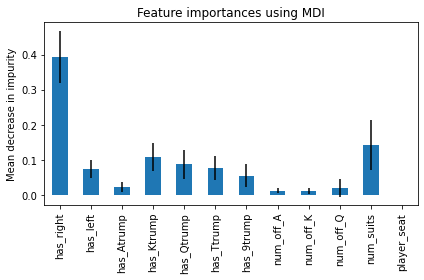

In [213]:
forest_importances = pd.Series(importances, index=model_features)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


#### GBM

In [182]:
from sklearn.ensemble import GradientBoostingClassifier

In [186]:
gbm_clf = GradientBoostingClassifier(learning_rate=0.1, 
                                     n_estimators=10, 
                                     subsample=1.0, 
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     max_depth=3)

#### Fit the model

In [187]:
%%time

gbm_clf.fit(train_df, train_targets_df)

Wall time: 22.2 s


GradientBoostingClassifier(n_estimators=10)

In [189]:
# Create test preds
#test_preds = gbm_clf.predict(test_df)
test_preds = gbm_clf.predict_proba(test_df)
test_preds[0:3]

array([[0.12269621, 0.20921646, 0.30001755, 0.28942605, 0.07115732,
        0.00748641],
       [0.12465375, 0.20466675, 0.27674786, 0.29404364, 0.08850242,
        0.01138557],
       [0.49954373, 0.29236459, 0.11290243, 0.06293431, 0.02600792,
        0.00624703]])

In [193]:
single_test_pred = gbm_clf.predict_proba(single_hand_test_df)
single_test_pred

array([[0.13002742, 0.15809862, 0.18382737, 0.18091696, 0.33954942,
        0.00758021]])

#### CV

In [196]:
from sklearn.model_selection import GridSearchCV

In [204]:
grid_params = {'n_estimators':[10,20]}

In [205]:
clf = GridSearchCV(classifier, grid_params)

In [206]:
%%time

clf.fit(train_df, train_targets_df)

Wall time: 1min 10s


GridSearchCV(estimator=RandomForestClassifier(criterion='entropy',
                                              max_features=1.0),
             param_grid={'n_estimators': [10, 20]})

In [207]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [208]:
clf.cv_results_

{'mean_fit_time': array([4.2941927 , 8.28017459]),
 'std_fit_time': array([0.10050237, 0.02841427]),
 'mean_score_time': array([0.16567979, 0.30998254]),
 'std_score_time': array([0.00842644, 0.00676481]),
 'param_n_estimators': masked_array(data=[10, 20],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 10}, {'n_estimators': 20}],
 'split0_test_score': array([0.60515028, 0.60574515]),
 'split1_test_score': array([0.60422668, 0.60396055]),
 'split2_test_score': array([0.60253601, 0.60267689]),
 'split3_test_score': array([0.60967439, 0.60865686]),
 'split4_test_score': array([0.60437703, 0.60486232]),
 'mean_test_score': array([0.60519288, 0.60518035]),
 'std_test_score': array([0.00239766, 0.00201303]),
 'rank_test_score': array([1, 2])}

In [209]:
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_features=1.0, n_estimators=10)

In [212]:
clf.best_estimator_.predict_proba(single_hand_test_df)

array([[0.01307361, 0.22641135, 0.59745315, 0.16306189, 0.        ,
        0.        ]])

#### Save out model to disk using joblib

In [98]:
import joblib

In [99]:
pwd

'C:\\Users\\jerem\\Desktop\\nonsense\\euchre'

In [100]:
joblib.dump(classifier, 'C:/Users/jerem/Desktop/nonsense/euchre/models/trick_model_rf_v0.sav')

['C:/Users/jerem/Desktop/nonsense/euchre/models/trick_model_rf_v0.sav']

#### Plot probability output

In [110]:
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
num_tricks_taken = ['0','1','2','3','4','5']
ax.bar(num_tricks_taken, single_hand_preds.tolist()[0])

plt.xlabel("Tricks taken")
plt.ylabel("Percent of hands")
plt.title("Expected tricks taken")

# ax.bar_label(trick_preds, label_type='center')

plt.show()

In [ ]:
def plot_expected_tricks_taken(expected_tricks_taken):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(['0','1','2','3','4','5'], expected_tricks_taken)
    plt.xlabel("Tricks taken")
    plt.ylabel("Percent of hands")
    plt.title("Expected tricks taken")
    plt.show()

In [ ]:
plot_expected_tricks_taken(expected_tricks_taken = trick_preds)

### Evalute model

In [28]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [165]:
mean_absolute_error(y_true=test_targets_df, y_pred=test_preds)

0.5052282970054095

In [166]:
mean_squared_error(y_true=test_targets_df, y_pred=test_preds)

0.6878913277013927

In [167]:
r2_score(y_true=test_targets_df, y_pred=test_preds)

0.5508392854731867

#### Pipeline

In [168]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [169]:
categorical_columns = ['player_seat']
categorical_encoder = OneHotEncoder()

In [171]:
preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
    ],
)

In [172]:
rf = Pipeline(
    [
        ('preprocess', preprocessing),
        ('classifier', RandomForestClassifier(random_state=123))
    ]

)

In [173]:
rf.fit(train_df, train_targets_df)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['player_seat'])])),
                ('classifier', RandomForestClassifier(random_state=123))])

In [174]:
rf

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['player_seat'])])),
                ('classifier', RandomForestClassifier(random_state=123))])

In [179]:
single_hand_preds = rf.predict_proba(single_hand_test_df)
single_hand_preds

array([[0.34107464, 0.30962382, 0.17939596, 0.10710813, 0.05166994,
        0.01112752]])

## Next Steps

In [ ]:
# Features - make player position at table categorical

# Build separate model for team tricks won

# Standardize input features to linear model
# Cross-validate tree-based models - RF, GBM, etc.
# sklearn pipeline

# PyTorch models
    # compare PyTorch version vs. sklearn
# Classification models to predict likelihood for each score outcome

# Is it possible to take a trick with an off-suit Jack, that wouldn't have been taken with the 10 or 9 ???

# Is there ever a time when knowing the current score of the game should affect which card to play?
    # If opponent has 9 points, play more aggressively?

# Is there ever a time when knowing the current number of tricks taken should affect which card to play?
    # If opponents have taken 2 tricks already, play more aggressively?


In [102]:
def translate_st_input_to_df(trump, 
                             a_s=False, k_s=False, q_s=False, j_s=False, t_s=False, nine_s=False, 
                             j_c=False):
    """
    Function to take in checkbox inputs and return
    
    :return dataframe
    """
    model_features = ['has_right', 'has_left',
                      'has_Atrump', 'has_Ktrump', 'has_Qtrump', 'has_Ttrump', 'has_9trump',
                      'num_off_A', 'num_off_K', 'num_off_Q'
                      ]
    hand = {feature: [0] for feature in model_features}
    df = pd.DataFrame(hand)
    if trump == 'SPADES':
        if a_s:
            df['has_Atrump'] = 1
        if k_s:
            df['has_Ktrump'] = 1
        if q_s:
            df['has_Qtrump'] = 1
        if j_s:
            df['has_right'] = 1
        if t_s:
            df['has_Ttrump'] = 1
        if nine_s:
            df['has_9trump'] = 1
        if j_c:
            df['has_left'] = 1

    if trump == 'CLUBS':
        if a_c:
            df['has_Atrump'] = 1
        if k_c:
            df['has_Ktrump'] = 1
        if q_c:
            df['has_Qtrump'] = 1
        if j_c:
            df['has_right'] = 1
        if t_c:
            df['has_Ttrump'] = 1
        if nine_c:
            df['has_9trump'] = 1
        if j_s:
            df['has_left'] = 1

    if trump == 'DIAMONDS':
        if a_d:
            df['has_Atrump'] = 1
        if k_d:
            df['has_Ktrump'] = 1
        if q_d:
            df['has_Qtrump'] = 1
        if j_d:
            df['has_right'] = 1
        if t_d:
            df['has_Ttrump'] = 1
        if nine_d:
            df['has_9trump'] = 1
        if j_h:
            df['has_left'] = 1

    if trump == 'HEARTS':
        if a_h:
            df['has_Atrump'] = 1
        if k_h:
            df['has_Ktrump'] = 1
        if q_h:
            df['has_Qtrump'] = 1
        if j_h:
            df['has_right'] = 1
        if t_h:
            df['has_Ttrump'] = 1
        if nine_h:
            df['has_9trump'] = 1
        if j_d:
            df['has_left'] = 1

    return df

In [103]:
translate_st_input_to_df(trump='S', 
                         a_s=False,
                         k_s=False,
                         q_s=False,
                         j_s=False, 
                         t_s=False,
                         nine_s=False,
                         j_c=False)

,has_right,has_left,has_Atrump,has_Ktrump,has_Qtrump,has_Ttrump,has_9trump,num_off_A,num_off_K,num_off_Q
0,0,0,0,0,0,0,0,0,0,0


In [151]:
def count_suits_st_input(trump: str,
                             a_s=False, k_s=False, q_s=False, j_s=False, t_s=False, nine_s=False,
                             a_c=False, k_c=False, q_c=False, j_c=False, t_c=False, nine_c=False,
                             a_d=False, k_d=False, q_d=False, j_d=False, t_d=False, nine_d=False,
                             a_h=False, k_h=False, q_h=False, j_h=False, t_h=False, nine_h=False):
    """
    :return int of number of suits
    """
    suits = set()
    if trump == 'HEARTS':
        if a_h or k_h or q_h or j_h or j_d or t_h or nine_h:
            suits.add('h')
        if a_d or k_d or q_d or t_d or nine_d:
            suits.add('d')
        if a_s or k_s or q_s or j_s or t_s or nine_s:
            suits.add('s')
        if a_c or k_c or q_c or j_c or t_c or nine_c:
            suits.add('c')
    return len(suits)

In [157]:
count_suits_st_input(trump='HEARTS', 
                     a_s=False, k_s=False, q_s=False, j_s=False, t_s=False, nine_s=False,
                             a_c=True, k_c=False, q_c=False, j_c=False, t_c=False, nine_c=False,
                             a_d=False, k_d=False, q_d=False, j_d=True, t_d=False, nine_d=False,
                             a_h=False, k_h=True, q_h=False, j_h=False, t_h=False, nine_h=False
                    )

2